In [1]:
import pandas as pd

In [2]:
import numpy

In [3]:
import sklearn

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data  =pd.read_csv("C:/Users/AJ00635713/Desktop/data-1.csv",header = None,nrows = 30000)
data.columns = ['id','ask','base_volume','bid','date','high','last','low','marketName','moy_prev_day','open_buy_orders',
               'open_sell_orders','volume']

In [6]:
data.head()

,id,ask,base_volume,bid,date,high,last,low,marketName,moy_prev_day,open_buy_orders,open_sell_orders,volume
0,0,4261.906148,9333.620962,4261.053852,2019-07-11 00:06:04,4280.56,4261.48,4261.48,BTC-USDT,4261.48,2,7,2.189061
1,1,4261.876145,38891.133046,4261.023855,2019-07-11 00:06:04,4270.41,4261.45,4261.32,BTC-USDT,4261.48,15,25,9.119865
2,2,4310.501007,94080.917568,4309.638993,2019-07-11 00:06:04,4310.07,4310.07,4267.99,BTC-USDT,4261.45,54,4,21.923552
3,3,4309.260883,60060.466816,4308.399117,2019-07-11 00:06:04,4313.62,4308.83,4291.37,BTC-USDT,4310.07,50,14,13.948531
4,4,4304.740431,22006.533111,4303.879569,2019-07-11 00:06:04,4328.69,4304.31,4304.31,BTC-USDT,4308.83,30,14,5.101153


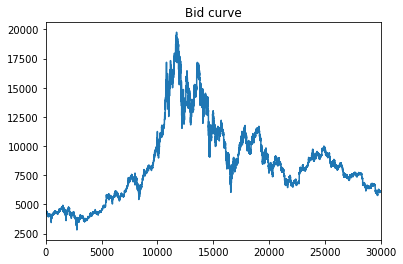

In [7]:
#pd.to_datetime(data['open time'],unit='s')
data['last'].plot(label="bid", title="Bid curve")
#data.columns

In [8]:
# Peaks detection function
import numpy as np

def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
    if x is None:
        x = np.arange(len(v))
    v = np.asarray(v)
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    lookformax = True
    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]

        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

In [9]:
peaksmax, peaksmin =  peakdet(data['last'] ,0.065)

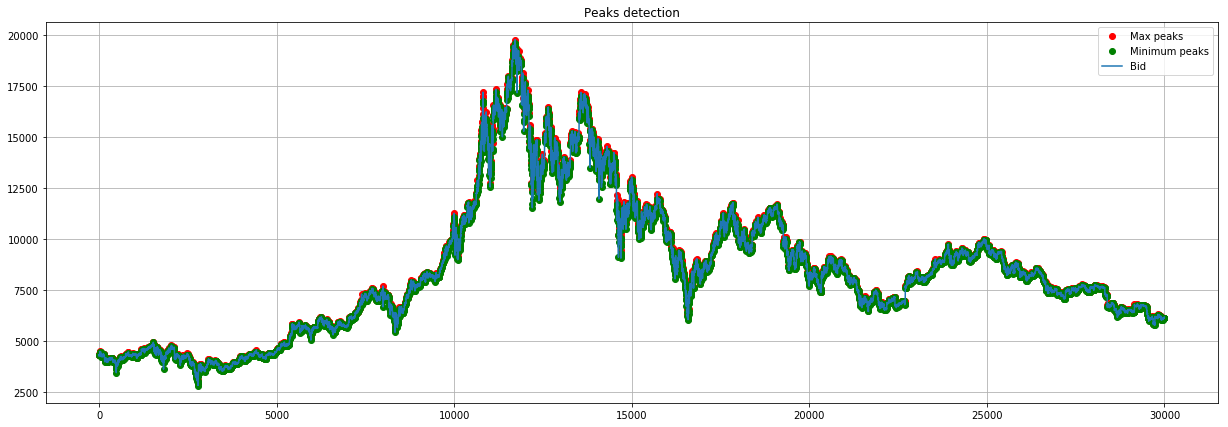

In [10]:
fig = plt.figure(figsize=(21,7))
plt.plot(peaksmax[:,0], peaksmax[:, 1], 'ro', label="Max peaks")
plt.plot(peaksmin[:,0], peaksmin[:, 1], 'go', label="Minimum peaks")
plt.plot(data["last"], label="Bid")
plt.grid()
plt.title("Peaks detection")
plt.legend()
plt.show()

In [11]:
# Frame labelization functions
def setSell(idx, peaksmax, peaksmin):
    for i in peaksmax:
        if i[0] == idx:
            return 1.0
    for i in peaksmin:
        if i[0] == idx:
            return 0.0
    return 0.0

def setWait(idx, peaksmax, peaksmin):
    for i in peaksmax:
        if i[0] == idx:
            return 0.0
    for i in peaksmin:
        if i[0] == idx:
            return 0.0
    return 1.0

def setBuy(idx, peaksmax, peaksmin):
    for i in peaksmax:
        if i[0] == idx:
            return 0.0
    for i in peaksmin:
        if i[0] == idx:
            return 1.0
    return 0.0

def frame_labelization(frame_base, maxp, minp, data):
    frame_base["wait"] = [setWait(d, maxp, minp) for d in range(len(data["last"]))]
    frame_base["sell"] = [setSell(d, maxp, minp) for d in range(len(data["last"]))]
    frame_base["buy"] = [setBuy(d, maxp, minp) for d in range(len(data["last"]))]
    return frame_base

In [12]:
#normalize_data_tmp = 
# NORMALIZATION OF THE DATA
features = ["ask", "bid", "high", "low", "moy_prev_day"]
labelisation_labels_name = ["buy", "sell", "wait"]
normalize_data = data[features]

In [13]:
normalize_data_tmp  = frame_labelization(data, peaksmax, peaksmin, data)

In [14]:
def generate_data(dataset, timestep, xcols, ycols):
    dx, dy = [], []
    for i in range(len(dataset) - timestep):
        a = dataset.iloc[i : i + timestep][xcols]
        dx.append(np.array(a))
        dy.append(dataset.iloc[i + timestep  - 1][ycols])
    return np.array(dx), np.array(dy)

def split_train(frame, train_per, test_per, timestep, xcols, ycols, balance=False):
    x_tmp, y_tmp = generate_data(frame, timestep, xcols, ycols)
    if balance is True:
        x_tmp, y_tmp =  balancelabelisation(x_tmp, y_tmp)
    train_size = int(x_tmp.shape[0] * train_per)
    test_size = int(x_tmp.shape[0] * test_per) + train_size

    x_train = x_tmp[: train_size]
    y_train = y_tmp[: train_size]
    x_test = x_tmp[train_size : test_size]
    y_test = y_tmp[train_size : test_size]
    return x_train, y_train, x_test, y_test

def balancelabelisation(frame, label):
    buy = int(label[:,0].sum())
    sell = int(label[:,1].sum())
    wait = int(label[:,2].sum())
    need_delete = wait - min(sell, buy)
    tab_wait = [i for i, l in enumerate(label)if l[2] == 1]
    rand_delete = np.random.choice(tab_wait, need_delete, replace=False)
    final_frame = np.delete(frame, rand_delete, axis=0)
    final_label = np.delete(label, rand_delete, axis=0)
    final_frame = np.array(final_frame)
    final_label = np.array(final_label)
    return final_frame, final_label

x_train, y_train, x_test, y_test = split_train(normalize_data_tmp,
                                                     0.7,
                                                     0.3,
                                                     50,
                                                     features,
                                                     labelisation_labels_name,
                                                     balance=True)

In [15]:
x_train[1:5]

array([[[4310.501007, 4309.638993, 4310.07    , 4267.99    ,
         4261.45    ],
        [4309.260883, 4308.399117, 4313.62    , 4291.37    ,
         4310.07    ],
        [4304.740431, 4303.879569, 4328.69    , 4304.31    ,
         4308.83    ],
        [4320.432   , 4319.568   , 4320.      , 4312.14    ,
         4304.31    ],
        [4291.799137, 4290.940863, 4320.      , 4291.37    ,
         4320.      ],
        [4315.751532, 4314.888468, 4315.32    , 4297.04    ,
         4291.37    ],
        [4330.433   , 4329.567   , 4330.29    , 4318.39    ,
         4315.32    ],
        [4311.451102, 4310.588898, 4330.29    , 4309.37    ,
         4330.      ],
        [4345.884545, 4345.015455, 4345.45    , 4319.83    ,
         4311.02    ],
        [4324.782435, 4323.917565, 4345.45    , 4324.35    ,
         4345.45    ],
        [4317.051662, 4316.188338, 4316.62    , 4316.62    ,
         4324.35    ],
        [4291.809138, 4290.950862, 4291.38    , 4291.38    ,
         4316.6

In [16]:
y_train

array([[1.0, 0.0, 0.0],
       [0.0, 1.0, 0.0],
       [0.0, 0.0, 1.0],
       ...,
       [0.0, 0.0, 1.0],
       [0.0, 0.0, 1.0],
       [0.0, 1.0, 0.0]], dtype=object)

In [17]:
def lstmNeuronsNumber(frame):
    Ni = len(features)
    No = len(labelisation_labels_name)
    Ns = frame.shape[0]
    a = 2 #delta_neurons_numbers
    return int(Ns / (a * (Ni + No)))

In [18]:
model_lstm_neural = lstmNeuronsNumber(x_train)

In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(model_lstm_neural, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh',return_sequences=True))
model.add(LSTM(model_lstm_neural, activation='tanh'))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

model.summary()

Using TensorFlow backend.
W0711 15:08:27.491630  9844 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras-2.2.4-py3.7.egg\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 15:08:27.507622  9844 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras-2.2.4-py3.7.egg\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 15:08:27.509620  9844 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras-2.2.4-py3.7.egg\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0711 15:08:31.522338  9844 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras-2.2.4-py3.7.egg\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.co

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 1021)          4194268   
_________________________________________________________________
lstm_2 (LSTM)                (None, 1021)              8343612   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3066      
Total params: 12,540,946
Trainable params: 12,540,946
Non-trainable params: 0
_________________________________________________________________


In [21]:
import keras

class PlotRealTime(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.acc, 'g', label="accuracy")
        plt.plot(self.x, self.val_acc, 'r', label="validation accuracy")
        plt.legend()
        plt.title("Accuracy percentage")
        plt.grid()
        plt.show()
        
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.title("Losses percentage")
        plt.grid()
        plt.show()

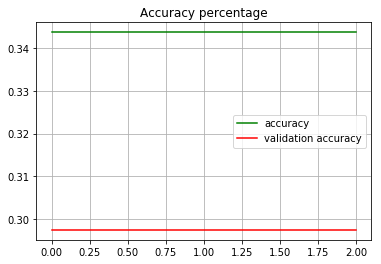

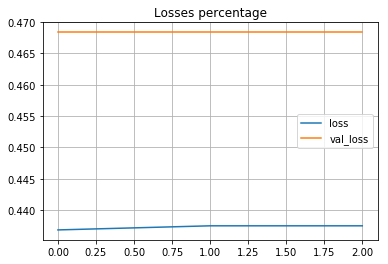

Epoch 4/70

Epoch 00004: LearningRateScheduler setting learning rate to 0.01.
12500/14702 [========================>.....] - ETA: 2:19 - loss: 0.4376 - acc: 0.3436

In [ ]:
plotRT = PlotRealTime()
from keras.callbacks import LearningRateScheduler
from IPython.display import clear_output


# Learning stats
def lr(epoch):
    if epoch < 15:
        return 0.010
    if epoch < 40:
        return 0.0095
    if epoch < 55:
        return 0.008
    if epoch < 60:
        return 0.007
    if epoch < 150:
        return 0.01
    return 0.01
# TRAINING
hist = model.fit(x_train,
                 y_train, 
                 epochs=70,
                 batch_size=50,
                 validation_split=0.1,
                 verbose=1,
                 shuffle=True,
                 callbacks=[plotRT, LearningRateScheduler(lr, verbose=1)])
# EVALUATE
score , acc = model.evaluate(x_test, y_test, batch_size=100, verbose=1)

print("score: {}".format(score))
print("acc: {}".format(acc))